In [1]:
import pandas as pd
import os, re 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import seaborn as sns 

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.decomposition import PCA
from numpy.linalg import svd 

#PERMANOVA on SV1/SV2 sample projections of data 
from scipy.spatial import distance_matrix
from skbio.stats import distance as sk_distance 

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [2]:
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAXA_NAMES = ["B. breve","B. catenulatum","B. longum infantis 2D9","B. luti","B. obeum","D. formicigenerans",
                     "D. longicatena","E. avium","E. coli","F. prausnitzii","L. garvieae","L. ruminis",
                     "M. multacida","P. copri","P. stercorea","R. gnavus","R. torques","S. gallolyticus","S. pasteurianus"]

In [27]:
#Workspace set-up - data loading, figure directory configuration, final processing of dataset (these steps now 
#done earlier in workflow to subset to cecal contents and remove prevotella species)


# DATA_FILTERING = "tpm_prev"
DATA_FILTERING = "edgeR"

###========###
#Non-rlog filtered (ie tpm/prev)
###========###
if DATA_FILTERING == "tpm_prev":
    DATASET = "rlog"
    ABUNDANCE_CORRECTED_DATA = True

    if ABUNDANCE_CORRECTED_DATA:
        PARAM_STR = "thr3_prev0.25_cecal_nonprevotella_E7"
        figures_dir = "figures/4th_trial/{0}/SVD_{1}".format(PARAM_STR,DATASET)
        bpm_filt_data_path = "formatted_output/4th_trial/bpm_filtered_abundance_corrected/{0}".format(PARAM_STR) 
        lsv_data_path = "formatted_output/4th_trial/lsv_tables/abundance_corrected/{0}".format(PARAM_STR) 
    else: 
        PARAM_STR = "thr3_prev0.3_cecal_nonprevotella"
        figures_dir = "figures/4th_trial/{0}/SVD_{1}".format(PARAM_STR,DATASET)
        bpm_filt_data_path = "formatted_output/4th_trial/bpm_filtered/{0}".format(PARAM_STR) 
        lsv_data_path = "formatted_output/4th_trial/lsv_tables/uncorrected/{0}".format(PARAM_STR) 
elif DATA_FILTERING == "edgeR":
    DATASET = "rlog"
    PARAM_STR = "edgeR_filtered"
    
    figures_dir = "figures/4th_trial/edgeR_filtered/SVD_{0}".format(DATASET)
    bpm_filt_data_path = "formatted_output/4th_trial/edgeR_filtered"
    lsv_data_path = "formatted_output/4th_trial/lsv_tables/edgeR_filtered"

if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

In [28]:



bpm_filt_expr_fpath = "{0}/bpm_filt_{1}.csv".format(bpm_filt_data_path,DATASET)
# bpm_filt_expr_fpath = "{0}/mystery.csv".format(bpm_filt_data_path,DATASET)
pht_agg_expr_fpath = "{0}/bpm1_agg_pht_{1}.csv".format(bpm_filt_data_path,DATASET)
condensed_agg_expr_fpath = "{0}/condensed_agg_pht_{1}.csv".format(bpm_filt_data_path,DATASET)

bpm_filt_expr_df = pd.read_csv(bpm_filt_expr_fpath,index_col=0)
bpm_filt_expr_df.drop_duplicates(inplace=True)
pht_agg_expr_df = pd.read_csv(pht_agg_expr_fpath,index_col=0)
condensed_agg_expr_df = pd.read_csv(condensed_agg_expr_fpath,index_col=0)
SHOW_PRE_FILTERED = False
if SHOW_PRE_FILTERED:
    print("Pre-filtering:")
    display(bpm_filt_expr_df)
    display(condensed_agg_expr_df)

#Cecal contents only filtering 
cecal_filter = True 
if cecal_filter:
    cecal_bpm_filt_expr_df = bpm_filt_expr_df.loc[:,bpm_filt_expr_df.columns.str.contains("cecal")]
    bpm_filt_expr_df = cecal_bpm_filt_expr_df
    
    cecal_condensed_agg_df = condensed_agg_expr_df.loc[:,condensed_agg_expr_df.columns.str.contains("cecal")]
    condensed_agg_expr_df = cecal_condensed_agg_df

drop_prevotella = True 
if drop_prevotella:
    bpm_filt_expr_df = bpm_filt_expr_df.loc[~bpm_filt_expr_df.index.str.contains(r'NBCBLOMG|NJCFFJJN'),:]
    condensed_agg_expr_df = condensed_agg_expr_df.loc[~condensed_agg_expr_df.index.str.contains(r'Pst|Pco'),:]


feature_center = True
if feature_center:
    bpm_filt_expr_df = bpm_filt_expr_df.subtract(bpm_filt_expr_df.mean(axis=1),axis=0)
    condensed_agg_expr_df = condensed_agg_expr_df.subtract(condensed_agg_expr_df.mean(axis=1),axis=0)
    
assert(np.isclose(bpm_filt_expr_df.mean(axis=1).sum(),0))
assert(np.isclose(condensed_agg_expr_df.mean(axis=1).sum(),0))

#Convert so that samples are rows, features are columns (ie tranpose of previous data format)
data_tranpose = True 
if data_tranpose:
    if not bpm_filt_expr_df.index.str.contains("cecal").sum():
        bpm_filt_expr_df = bpm_filt_expr_df.transpose()
    if not condensed_agg_expr_df.index.str.contains("cecal").sum():
        condensed_agg_expr_df = condensed_agg_expr_df.transpose()
print("Post Filtering/Transpose")
display(bpm_filt_expr_df)
display(condensed_agg_expr_df)
        
        
# print("==BPM=1 Transcripts STD==")        
# display(bpm_filt_expr_df.std(axis=0))
# print("==BPM=1 Phenotypes STD==")        
# display(condensed_agg_expr_df.std(axis=0))

Post Filtering/Transpose


,ANCJAENF_00282,ANCJAENF_00283,ANCJAENF_00439,ANCJAENF_00597,ANCJAENF_00670,ANCJAENF_00671,ANCJAENF_00674,ANCJAENF_00675,ANCJAENF_01124,ANCJAENF_01125,...,LDOIJNDB_00908,LDOIJNDB_00635,LDOIJNDB_02060,LDOIJNDB_01022,LDOIJNDB_01273,LDOIJNDB_01683,LDOIJNDB_01949,LDOIJNDB_00521,LDOIJNDB_01036,LDOIJNDB_00003
Pup_1.cecal_contents_53_1C_Pup_1,1.123510,1.039287,1.077205,0.995703,1.128514,-0.056727,1.443845,1.218293,1.009354,0.468856,...,0.510453,0.103634,0.932764,-0.308935,0.105072,0.105095,0.095594,-0.185793,-0.165147,-0.183033
Pup_2.cecal_contents_53_1C_Pup_2,-0.295258,0.705847,0.670553,-0.386038,1.204476,0.420912,-0.021115,0.501113,0.043657,-0.246173,...,-0.262388,0.135858,0.163433,0.383993,0.060563,0.017503,0.043961,0.552008,0.644850,0.400783
Pup_3.cecal_contents_53_1C_Pup_3,1.438414,1.184470,1.132586,1.176503,0.940294,0.523524,1.562590,1.492706,0.995854,0.433130,...,-0.043316,0.586714,0.967275,0.426507,0.736929,1.226721,0.394150,0.477573,0.364627,0.903362
Pup_4.cecal_contents_53_1C_Pup_4,1.031755,0.715275,1.259790,1.239884,0.696541,-0.275992,0.998616,0.951828,1.147559,0.814821,...,0.479790,-0.067245,-0.527977,0.134030,-0.415607,0.126835,0.316002,1.308286,0.577866,0.749702
Pup_5.cecal_contents_53_1C_Pup_5,0.761807,0.578793,0.676714,0.668393,0.551315,0.264719,0.458567,0.549315,0.607667,0.252872,...,0.366466,-0.339314,-0.232405,-0.534495,-0.316368,0.013286,-0.587457,0.024097,-0.101545,-0.417436
Pup_6.cecal_contents_53_1C_Pup_6,2.306892,1.018908,0.353582,0.168022,-0.010598,0.685551,0.925951,0.227805,-0.606989,-0.225505,...,-0.643556,-1.233667,-1.489087,-0.729497,-1.396411,0.378298,-0.862245,0.154856,-0.203492,-0.407258
Pup_7.cecal_contents_53_1C_Pup_7,0.817129,0.639433,0.868441,0.808339,0.667213,0.020671,0.572997,0.745495,0.545509,0.131225,...,0.153803,0.253131,0.369728,-0.050278,0.068107,0.455854,-0.414841,0.236246,0.289894,0.296469
Pup_8.cecal_contents_53_1C_Pup_8,0.254908,0.372590,0.562805,0.269348,1.712305,1.286945,0.782358,0.586767,0.389490,0.032304,...,0.194448,0.621276,0.665740,0.408667,0.545892,-0.158788,0.019964,0.064316,0.207491,0.487122
Pup_1.cecal_contents_54_2B_Pup_1,-1.060106,0.613971,-0.263721,-0.149850,-1.053007,-0.019994,0.765472,0.613047,0.846918,-0.559372,...,0.545896,0.762822,0.973939,1.290031,0.867611,1.054511,1.166739,1.306976,1.130805,0.704566
Pup_2.cecal_contents_54_2B_Pup_2,2.025672,-2.409883,-0.702601,0.918103,-2.938135,-2.341368,-3.001704,-2.746973,-2.864313,1.076117,...,-1.705645,-0.891936,-1.099726,-1.452245,-0.749085,-1.955913,-1.140060,-1.980813,-2.098882,-1.687833


,Bbr_Glc,Bbr_Fru,Bbr_NANA,Bbr_Fuc,Bbr_Rbs,Bbr_Mal,Bbr_Scr,Bbr_Lnb,Bbr_Lac,Bbr_Mtl,...,Spa_Asn,Spa_B2,Spa_B3,Spa_B9,Spa_Q,Spa_Acetate,Spa_Formate,Spa_L-Lactate,Spa_Ethanol,Spa_CA_d
Pup_1.cecal_contents_53_1C_Pup_1,1.058926,0.808646,1.456452,0.758751,1.045657,0.935767,0.372681,1.045248,1.050573,1.128514,...,0.401045,-0.180259,-0.043734,0.332372,0.248401,0.518199,-0.101932,0.100345,-0.178911,-0.183033
Pup_2.cecal_contents_53_1C_Pup_2,0.173776,0.508994,0.936096,-0.130203,0.953992,0.070495,0.335202,-0.312454,0.629483,1.204476,...,-0.466461,-0.263685,-0.254365,-0.514788,-0.048052,0.149646,0.222278,0.030732,0.582956,0.400783
Pup_3.cecal_contents_53_1C_Pup_3,1.232993,1.021675,1.586431,0.878252,1.363125,0.825187,0.565520,1.162343,1.004478,0.940294,...,0.529168,0.399840,0.478344,0.654215,0.182537,0.776995,0.581718,0.810436,0.439925,0.903362
Pup_4.cecal_contents_53_1C_Pup_4,1.061676,0.541895,1.890266,1.042733,1.034797,1.017049,1.173167,1.025227,1.181949,0.696541,...,-0.312015,0.264389,-0.275984,-0.336793,0.384909,-0.297611,-0.140789,0.221419,1.064813,0.749702
Pup_5.cecal_contents_53_1C_Pup_5,0.671427,0.539159,1.285134,0.255865,0.898788,0.413327,0.615113,0.537248,0.797799,0.551315,...,0.020025,0.151004,0.208146,0.027859,0.055080,-0.285859,-0.425432,-0.287085,-0.017783,-0.417436
Pup_6.cecal_contents_53_1C_Pup_6,0.961851,1.000188,1.518972,0.316986,0.161533,0.307953,-0.137501,0.536733,0.545217,-0.010598,...,-0.798644,-0.050544,-0.289620,0.238785,-0.565621,-1.361377,-1.062954,-0.241973,0.035407,-0.407258
Pup_7.cecal_contents_53_1C_Pup_7,0.783336,0.536112,2.197227,0.606632,0.965607,0.688704,0.117907,0.719859,0.665121,0.667213,...,-0.238120,0.313931,0.211035,-0.032765,0.028874,0.311430,0.008914,0.020507,0.254129,0.296469
Pup_8.cecal_contents_53_1C_Pup_8,0.364913,0.906687,-1.019033,0.926322,0.262159,0.948399,1.024265,0.391438,0.473784,1.712305,...,0.336475,0.068768,0.213002,0.278978,0.348033,0.643508,0.477279,-0.069412,0.112041,0.487122
Pup_1.cecal_contents_54_2B_Pup_1,-0.214927,-0.379784,-1.067922,-0.348335,0.425996,-0.217257,-0.196744,0.245775,1.195594,-1.053007,...,1.144339,0.688435,0.821550,0.586774,0.357792,0.868381,1.078821,1.110625,1.248253,0.704566
Pup_2.cecal_contents_54_2B_Pup_2,-0.042177,-1.415929,-2.852679,-0.835301,-2.158652,-1.609744,-2.109361,-1.837268,-1.815948,-2.938135,...,-0.855355,-0.677845,-0.751217,-0.841378,-1.072050,-0.995831,-1.100665,-1.547987,-2.020169,-1.687833


In [29]:
# Sanity check for locus inclusion 
# display(bpm_filt_expr_df["HIAFFLEM_01096"])

select_phts = ["Rob_Xyl","Rob_Ara","Rob_Gln","Rob_Acetate","Mmu_Ara","Mmu_Glu","Mmu_Leu"]
select_phts_df = condensed_agg_expr_df[select_phts]

display(select_phts_df.iloc[:8,:].mean())
display(select_phts_df.iloc[8:,:].mean())
# display(condensed_agg_expr_df["Rob_Leu"])


Rob_Xyl        2.335753
Rob_Ara        2.402600
Rob_Gln        1.954078
Rob_Acetate    2.579495
Mmu_Ara        2.423793
Mmu_Glu        1.861440
Mmu_Leu        1.879601
dtype: float64

Rob_Xyl       -2.669432
Rob_Ara       -2.745828
Rob_Gln       -2.233232
Rob_Acetate   -2.947994
Mmu_Ara       -2.770049
Mmu_Glu       -2.127360
Mmu_Leu       -2.148115
dtype: float64

From np.linalag.svd:
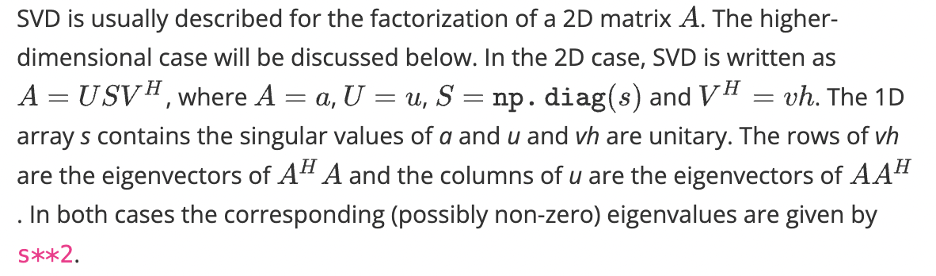

In [30]:
def sv_projections(feature_df,u,s,vh,pc_indices=[0,1],axis=0):
    """Return projections of feature_df onto singular vectors specified by axis 
        feature_df: samples (index) x features (columns)
        u: Matrix of left singular vectors (columns) - n_samples x n_samples
        s: singular values (vector) 
        vh: Matrix of right singular vectors (columns) - n_features x n_features
        pc_indices: list-like of indicies for which singular vectors to generate projections on  
        axis: 0 or 1, for generating sample projections or feature projections respectively 
    """
    #Generate PCs, a len(pc_indices) x {n_samples or n_features} ndarray representing the PCs specified 
    #by pc_indices and axis
    if axis == 0: #sample projections 
        SVs = vh[pc_indices,:]# n_PCs x n_features 
        data = feature_df.values.transpose() #n_features x n_samples
        assert(SVs.shape[1] == data.shape[0])
    elif axis == 1: #feature projections
        SVs = u[:,pc_indices].transpose() #n_PCs x n_samples
        data = feature_df.values #n_samples x n_features 
        assert(SVs.shape[1] == data.shape[0])
    else: 
        raise ValueError("axis must be 0 (sample projections) or 1 (feature projections)")
    #projections = PCs * data
    projections = np.dot(SVs,data)
    return projections
    
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def sig_str_from_pval(pval):
    if pval < 0.0001: 
        sig_str = "****"
    elif pval < 0.001: 
        sig_str = "***"
    elif pval < 0.01: 
        sig_str = "**"
    elif pval < 0.05: 
        sig_str = "*"
    else:
        sig_str = "ns"
    return sig_str

def standardize_plot_style(ax,xlabel,ylabel,title,legend_labels=[],title_size=16,ax_label_size=14,legend_cols=1,
                          legend_title=""):
    ticklabels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight("bold") for label in ticklabels]
    ax.set_xlabel(xlabel,weight="bold",fontsize=ax_label_size)
    ax.set_ylabel(ylabel,weight="bold",fontsize=ax_label_size)
    
    handles,labels = ax.get_legend_handles_labels()
    if len(legend_labels) > 0:
        ax.legend(handles,legend_labels,loc="best",title=legend_title)
    else:
        ax.legend(handles,labels,loc="best",title=legend_title)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1),ncol=legend_cols)
    ax.set_title(title,weight="bold",fontsize=title_size)

Permanova p-value: 0.000110
Permanova p-value: 0.000080


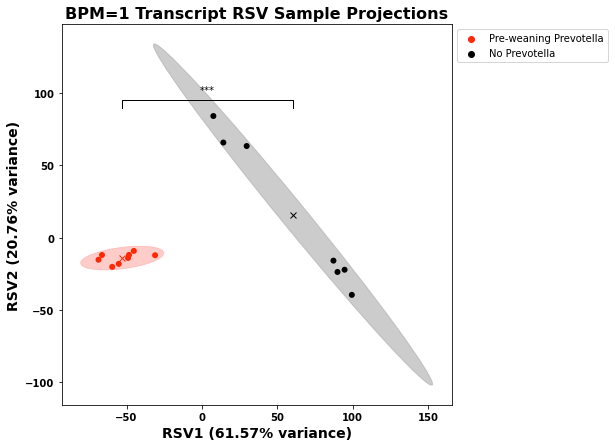

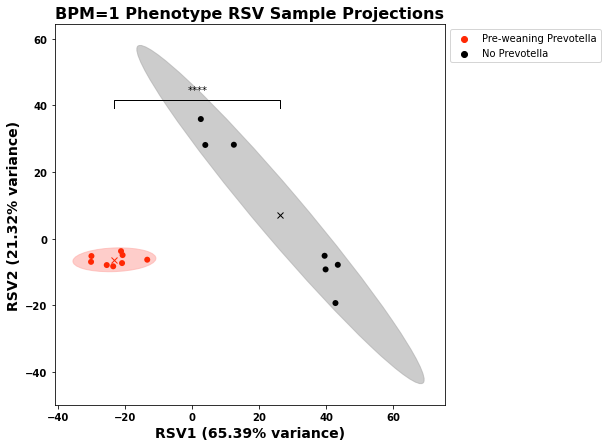

In [31]:
def sample_projections_scatter(expr_df, pc_indices,sample_arm_re=r'[\w_]+\.[\w_]+_([12][ABC])_[\w+]',title_str="",
                              figure_fpath="",arm_labels=["Pre-weaning Prevotella","No Prevotella"]): 
    #Palettes 
    HWDC_points_palette = ["#FF2804","#000000"]
    HWDC_ellipses_palette = ["#FEACA7","#AAAAAA"]
    
    #SVD, explained variance calculations 
    u,s,vh = svd(expr_df)
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    
    #Sample projections
    pc_indices = [0,1]
    sample_projections = sv_projections(expr_df,u,s,vh,pc_indices=pc_indices)
    sample_proj_df = pd.DataFrame(data=sample_projections.T,columns=["RSV1","RSV2"])
    sample_proj_df.loc[:,"Arm"] = expr_df.index.str.extract(sample_arm_re)
    
    v1 = sample_projections.T #M vectors in K dimensions = n_samples x n_PCs
    #permanova requires a skbio.stats.distance.DistanceMatrix object, must convert output  
    sp_dm = sk_distance.DistanceMatrix(distance_matrix(v1,v1,p=2))

    skpa = sk_distance.permanova(distance_matrix=sp_dm,grouping=sample_proj_df["Arm"],permutations=100000)
    skpa_p = skpa["p-value"]
    sig_str = sig_str_from_pval(skpa_p)
    print("Permanova p-value: {:.6f}".format(skpa_p))
    #Scatter plot of sampel projections using 
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    point_palette=HWDC_points_palette
    ellipses_palette = HWDC_ellipses_palette
    sns.scatterplot(data=sample_proj_df,x="RSV1",y="RSV2",hue="Arm",palette=point_palette,zorder=1,linewidth=0)
    
    #Get sample projections subsetted by arm (1C vs 2B), as well as cluster centers for arm
    sample_proj_1C = sample_proj_df.loc[sample_proj_df["Arm"] == "1C",:]
    center_1C_x, center_1C_y = np.mean(sample_proj_1C["RSV1"]),np.mean(sample_proj_1C["RSV2"])
    sample_proj_2B  = sample_proj_df.loc[sample_proj_df["Arm"] == "2B",:]
    center_2B_x, center_2B_y = np.mean(sample_proj_2B["RSV1"]),np.mean(sample_proj_2B["RSV2"])
    #Cluster center markers 
    ax.plot(center_1C_x,center_1C_y,c=point_palette[0],marker='x')
    ax.plot(center_2B_x,center_2B_y,c=point_palette[1],marker='x')
    #Confidence ellipses around each cluster - TODO: adjust n_std to correspond to 95% confidence in 2D (1D equiv of .975)
    ellipse1_c, ellipse2_c = ellipses_palette
    confidence_ellipse(x=sample_proj_1C["RSV1"],y=sample_proj_1C["RSV2"],ax=ax,n_std=2.25,
                       edgecolor=ellipse1_c,facecolor=ellipse1_c,alpha=0.6,zorder=0)
    confidence_ellipse(x=sample_proj_2B["RSV1"],y=sample_proj_2B["RSV2"],ax=ax,n_std=2.25,
                       edgecolor=ellipse2_c,facecolor=ellipse2_c,alpha=0.6,zorder=0)
    #Pyplot Formatting - axis and tick labels, title
    xlabel = "RSV{0} ({1}% variance)".format(pc_indices[0]+1,"%.2f" % (expl_variance[pc_indices[0]]*100))
    ylabel = "RSV{0} ({1}% variance)".format(pc_indices[1]+1,"%.2f" % (expl_variance[pc_indices[1]]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_labels=arm_labels)
    #Significance bracket: x1, x2 = cluster centers (x); y2 = bar y position, y1 = bracket extent 
    x1, x2 = center_1C_x, center_2B_x
    ymin, ymax = ax.get_ylim()
    y2 = ymax - (ymax-ymin)*.2
    y1 = y2-(ymax-ymin)*.02
    plt.text((x1+x2)*.5, y2+(ymax-ymin)*.015, sig_str, ha='center', va='bottom', color='k')
    plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    if figure_fpath:
        plt.savefig(figure_fpath, dpi=300, facecolor='w',bbox_inches="tight",format="pdf")

pc_indices = [0,1]
title_str = "BPM=1 Transcript RSV Sample Projections"
figure_fpath = "{0}/bpm1_transcripts_SVD.pdf".format(figures_dir)
sample_projections_scatter(bpm_filt_expr_df,pc_indices,title_str=title_str,figure_fpath=figure_fpath)


pc_indices = [0,1]
title_str = "BPM=1 Phenotype RSV Sample Projections"
figure_fpath = "{0}/bpm1_condensed_pht_SVD.pdf".format(figures_dir)
sample_projections_scatter(condensed_agg_expr_df,pc_indices,title_str=title_str,figure_fpath=figure_fpath)
# sample_projections_scatter(filt_condensed_agg,pc_indices,title_str=title_str,figure_fpath=figure_fpath)

In [32]:
#TEST CELL# Comparing SVD feature projections and sklearn.PCA 
SHOW_VALIDATION_PCA = False

if SHOW_VALIDATION_PCA:
    u,s,vh = svd(condensed_agg_expr_df)
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)

    sample_arm_re = r'[\w_]+\.[\w_]+_([12][ABC])_[\w+]'
    sample_projections = sv_projections(condensed_agg_expr_df,u,s,vh,pc_indices=pc_indices)
    sample_proj_df = pd.DataFrame(data=sample_projections.T,columns=["RSV1","RSV2"])
    sample_proj_df.loc[:,"Arm"] = condensed_agg_expr_df.index.str.extract(sample_arm_re)

    display(sample_proj_df)

    pca = PCA(n_components=2)
    pca.fit(condensed_agg_expr_df)
    PCA_df = pd.DataFrame(pca.transform(condensed_agg_expr_df),columns=["PC1","PC2"])

    R_PCs = np.dot(np.diag(s[pc_indices]),vh[pc_indices,:]).T
    R_PCs = np.dot(vh[pc_indices,:].T,np.diag(s[pc_indices]))
    R_PC_df = pd.DataFrame(R_PCs,columns=["RPC1","RPC2"])
    sns.scatterplot(data=R_PC_df,x="RPC1",y="RPC2")



In [33]:
#Load mcseed_df for strain and phenotype annotations of feature projections 
formatted_dir = "formatted_input"
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(formatted_dir)

mcseed_df = pd.read_csv(mcseed_path)
mcseed_df.set_index("Locus tag",inplace=True)
mcseed_df_og = mcseed_df.copy()
# mcseed_list_phts = mcseed_df.copy()
for col in ["Functional category","Functional pathway", "Phenotype"]:
#     mcseed_list_phts.loc[:,col] = mcseed_list_phts.loc[:,col].str.split(";")
    mcseed_df.loc[:,col] = mcseed_df.loc[:,col].str.split(";")
    # display(mcseed_df)
# display(mcseed_list_phts)
mcseed_df = mcseed_df_og
display(mcseed_df)
strains = mcseed_df["Isolate name"].unique()

#STRAIN_TAGS maps full strain names to abbreviations 
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAGS = dict(zip(strains,STRAIN_ABBREVS))
SHORT_ABBREVS = [abbrev[:3] for abbrev in STRAIN_ABBREVS]
STRAIN_ABBREV_TO_FULL = dict(zip(SHORT_ABBREVS, strains))

pht_pathway_df = pd.DataFrame(columns=["Functional pathway","Functional category"])
for pht_str in mcseed_df["Phenotype"].unique():
    pht_str_matches = mcseed_df.loc[mcseed_df["Phenotype"]==pht_str]
    assert(len(pht_str_matches["Functional pathway"].unique())==1)
    functional_pathway = pht_str_matches.iloc[0]["Functional pathway"]
    functional_category = pht_str_matches.iloc[0]["Functional category"]
    split_phts = [pht.strip() for pht in pht_str.split(";")]
    split_paths = [cat.strip().title() for cat in functional_pathway.split(";")]
    for pht, cat in zip(split_phts,split_paths):
        pht_pathway_df.loc[pht,"Functional pathway"] = cat
    if len(functional_category.split(";")) == 1:
        pht_pathway_df.loc[split_phts,"Functional category"] = functional_category
        
display(pht_pathway_df["Functional category"].unique())
assert(len(pht_pathway_df.loc[pht_pathway_df["Functional category"].isna()])==0)
display(pht_pathway_df)

,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype
Locus tag,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_00052,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac
ANCJAENF_00063,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac
...,...,...,...,...,...,...
LDOIJNDB_02225,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_c,"PTS system, trehalose-specific IIC component (...",Carbohydrate utilization,trehalose utilization,Tre
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",Carbohydrate utilization,trehalose utilization,Tre
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac


array(['Carbohydrate utilization', 'Amino acids', 'Fermentation products',
       'Vitamins/cofactors', 'Other catabolic pathways'], dtype=object)

,Functional pathway,Functional category
Mal,Maltose Utilization,Carbohydrate utilization
(Mal)n,Maltooligosaccharides Utilization,Carbohydrate utilization
Gal,Galactose Utilization,Carbohydrate utilization
Lac,Lactose Utilization,Carbohydrate utilization
Xyl,Xylose Utilization,Carbohydrate utilization
...,...,...
LA,"Lipoate Cofactor, De Novo Synthesis",Vitamins/cofactors
But_ut,Butyrate Utilization,Other catabolic pathways
Pro_d,Proline Degradation,Other catabolic pathways
Hyl,Hyaluronic Acid Utilization,Carbohydrate utilization


In [34]:
# display(bpm_filt_expr_df) #Fix me - for filtering out high information content features from rest 
# display(condensed_agg_expr_df)
# filt_condensed_agg = condensed_agg_expr_df.loc[:,~condensed_agg_expr_df.columns.isin(bpm_filt_expr_df.columns)]
# display(filt_condensed_agg)

,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ANCJAENF_00282,-3.430570,-1.217382,Bifidobacterium breve Bgsng463_m5_93,FruA_bif,"PTS system, fructose-specific IIABC (EC 2.7.1....",Carbohydrate utilization,fructose utilization,Fru,Bbr
ANCJAENF_00282,-3.430570,-1.217382,Bifidobacterium breve Bgsng463_m5_93,PtsG_bif,"PTS system, glucose-specific IIABC (EC 2.7.1.69)",Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_00283,-3.254279,-0.721904,Bifidobacterium breve Bgsng463_m5_93,FruT,"Fructose utilization antiterminator, BglG family",Carbohydrate utilization,fructose utilization,Fru,Bbr
ANCJAENF_00283,-3.254279,-0.721904,Bifidobacterium breve Bgsng463_m5_93,GluT,"Glucose utilization antiterminator, BglG family",Carbohydrate utilization,glucose utilization,Glc,Bbr
ANCJAENF_00439,-4.184758,1.014080,Bifidobacterium breve Bgsng463_m5_93,GlcK,Glucokinase (EC 2.7.1.2),Carbohydrate utilization,glucose utilization,Glc,Bbr
...,...,...,...,...,...,...,...,...,...
LDOIJNDB_01949,0.001005,0.950142,Streptococcus pasteriuanus Bang_SAM2_39_S1,LdhA-L,L-lactate dehydrogenase (EC 1.1.1.27),Fermentation products,L-lactate production,L-Lactate,Spa
LDOIJNDB_00521,-2.255702,1.641664,Streptococcus pasteriuanus Bang_SAM2_39_S1,AADH,Acetaldehyde dehydrogenase (EC 1.2.1.10),Fermentation products,ethanol production,Ethanol,Spa
LDOIJNDB_00521,-2.255702,1.641664,Streptococcus pasteriuanus Bang_SAM2_39_S1,ADH,Alcohol dehydrogenase (EC 1.1.1.1),Fermentation products,ethanol production,Ethanol,Spa
LDOIJNDB_01036,-1.630403,1.408992,Streptococcus pasteriuanus Bang_SAM2_39_S1,ADH,Alcohol dehydrogenase (EC 1.1.1.1),Fermentation products,ethanol production,Ethanol,Spa


,LSV1,LSV2,Strain abbreviation,Phenotype
Bbr_Glc,-3.380686,-0.107228,Bbr,Glc
Bbr_Fru,-3.329648,0.377018,Bbr,Fru
Bbr_NANA,-6.091654,1.017411,Bbr,NANA
Bbr_Fuc,-3.114170,1.212052,Bbr,Fuc
Bbr_Rbs,-4.459723,1.160816,Bbr,Rbs
...,...,...,...,...
Spa_Acetate,-0.674163,0.280010,Spa,Acetate
Spa_Formate,-0.501707,1.151755,Spa,Formate
Spa_L-Lactate,-0.826847,0.661612,Spa,L-Lactate
Spa_Ethanol,-2.098358,1.499893,Spa,Ethanol


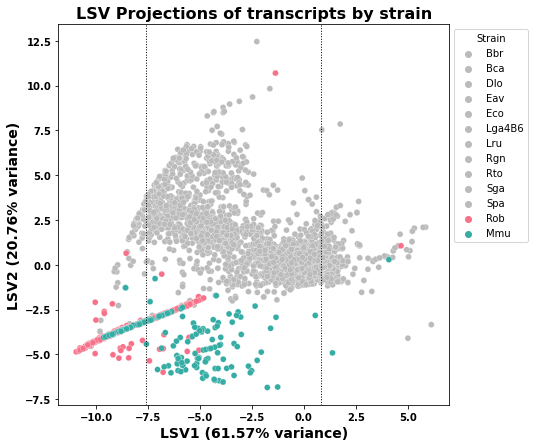

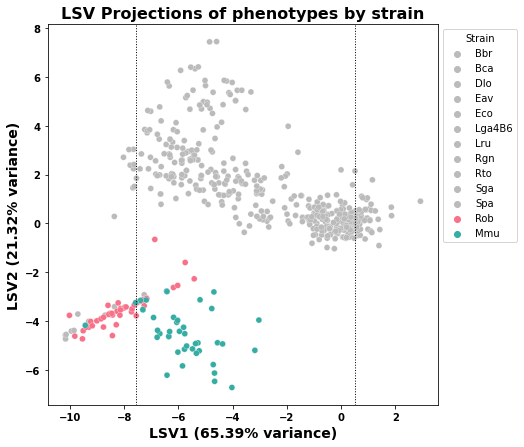

In [35]:
# def LSV_percentile_lines()
ROB_MMU_REST_PALETTE = dict(zip(STRAIN_ABBREVS,["#BBBBBB"]*len(STRAIN_ABBREVS)))
ROB_MMU_REST_PALETTE["Rob"] = "#EB8032"
ROB_MMU_REST_PALETTE["Mmu"] = "#639DF4"

# {"Rob":,"Mmu":,""}

def LSV_percentiles(fp_df,LSV_col="LSV1",percentile=10):
    n_features = len(fp_df)
    n_percentile_features = int(np.ceil(n_features * percentile/100))
    LSV_sorted = fp_df.sort_values(LSV_col)
    bottom, top = LSV_sorted.iloc[0:n_percentile_features,:],LSV_sorted.iloc[-n_percentile_features:]
    return bottom, top 

def LSV_percentile_vlines(fp_df,ax,LSV_col="LSV1",percentile=10):
    bottom_lsv, top_lsv = LSV_percentiles(fp_df,LSV_col,percentile)
    bottom_cutoff = bottom_lsv.iloc[-1][LSV_col]
    top_cutoff = top_lsv.iloc[0][LSV_col]
    ymin,ymax = ax.get_ylim()
    ax.vlines([bottom_cutoff,top_cutoff],ymin,ymax,color='black',linewidth=1,linestyles='dotted')
    ax.set_ylim(ymin,ymax)

def LSV_feature_projections(expr_df,pc_indices,mcseed_df,feature_type="transcript",title_str="",fig_fpath="",
                           partition_strains=[],partition_palette={}):
    if feature_type=="transcript":
        u,s,vh = svd(expr_df)
    elif feature_type=="phenotype":
        u,s,vh = svd(expr_df,full_matrices=True)
    else:
        raise ValueError("feature_type must be 'transcript' or 'phenotype'")
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    feature_projections = sv_projections(expr_df,u,s,vh,axis=1,pc_indices=pc_indices)
    PC_columns = ["LSV{0}".format(pc_idx+1) for pc_idx in pc_indices]
    fp_df = pd.DataFrame(data=feature_projections.T,columns=PC_columns)
    fp_df.set_index(expr_df.columns,inplace=True)
    
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    
    #mcseed annotation of fp_df 
    if feature_type=="transcript":
        mcseed_filt = mcseed_df.loc[mcseed_df.index.isin(fp_df.index),:]
        fp_mcseed_join = fp_df.merge(right=mcseed_filt,left_index=True,right_index=True,sort=True)
        fp_df_mcseed = fp_mcseed_join.loc[fp_df.index,:].drop_duplicates(subset=fp_mcseed_join.columns[:5])
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.loc[:,"Isolate name"].map(STRAIN_TAGS)
    elif feature_type=="phenotype":
        fp_df_mcseed = fp_df.copy()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.index.str.extract("(\w+?)\_[\w\-]+",expand=False)
        fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False) #comaptible with string format phenotypes
#         fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False)
    display(fp_df_mcseed)
    #Solo phenotype LSV Plot
    strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique())) #husl
    strain_palette = ROB_MMU_REST_PALETTE
    
    if len(partition_strains) > 0:
        if len(partition_palette) >0 :
            strain_palette = partition_palette
        else: 
            partition_palette = sns.color_palette("husl",len(partition_strains))
            rest_palette = dict(zip(list(fp_df_mcseed["Strain abbreviation"].unique()),
                                    ["#BBBBBB"]*len(fp_df_mcseed["Strain abbreviation"].unique())))
            strain_palette = rest_palette
            for i,strain in enumerate(partition_strains):
                strain_palette[strain] = partition_palette[i]
        #Use Z-order to prioritize partition
        fp_partition = fp_df_mcseed.loc[fp_df_mcseed["Strain abbreviation"].isin(partition_strains)]
        fp_rest = fp_df_mcseed.loc[~fp_df_mcseed["Strain abbreviation"].isin(partition_strains)]
        sns.scatterplot(data=fp_rest,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25,zorder=0)
        sns.scatterplot(data=fp_partition,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25,zorder=1)
    else:
        strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique()))
        sns.scatterplot(data=fp_df_mcseed,x="LSV1",y="LSV2",ax=ax,
                    palette=strain_palette,hue="Strain abbreviation",linewidth=0.25)
    xlabel = "{0} ({1}% variance)".format(PC_columns[0],"%.2f" % (expl_variance[0]*100))
    ylabel = "{0} ({1}% variance)".format(PC_columns[1],"%.2f" % (expl_variance[1]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_cols=1,legend_title="Strain")
    
#     bottom_percentile, top_percentile = LSV_percentiles(fp_df_mcseed,LSV_col="LSV{0}".format(pc_indices[0]+1))
    LSV_percentile_vlines(fp_df_mcseed,ax,LSV_col="LSV{0}".format(pc_indices[0]+1))
    if fig_fpath: 
        plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")
        
partition_strains = ["Rob","Mmu"]
# partition_strains = []
ROB_MMU_REST_PALETTE = dict(zip(STRAIN_ABBREVS,["#BBBBBB"]*len(STRAIN_ABBREVS)))
ROB_MMU_REST_PALETTE["Rob"] = "#EB8032"
ROB_MMU_REST_PALETTE["Mmu"] = "#639DF4"
        
title_str = "LSV Projections of transcripts by strain"
fig_fpath = "{0}/LSV_transcript_projections_by_strain.pdf".format(figures_dir)
LSV_feature_projections(bpm_filt_expr_df,pc_indices,mcseed_df,feature_type="transcript",
                       title_str=title_str,fig_fpath=fig_fpath,
                       partition_strains=partition_strains)

title_str = "LSV Projections of phenotypes by strain"
fig_fpath = "{0}/LSV_phenotype_projections_by_strain.pdf".format(figures_dir)
LSV_feature_projections(condensed_agg_expr_df,pc_indices,mcseed_df,feature_type="phenotype",
                       title_str=title_str,fig_fpath=fig_fpath,
                       partition_strains=partition_strains)
        


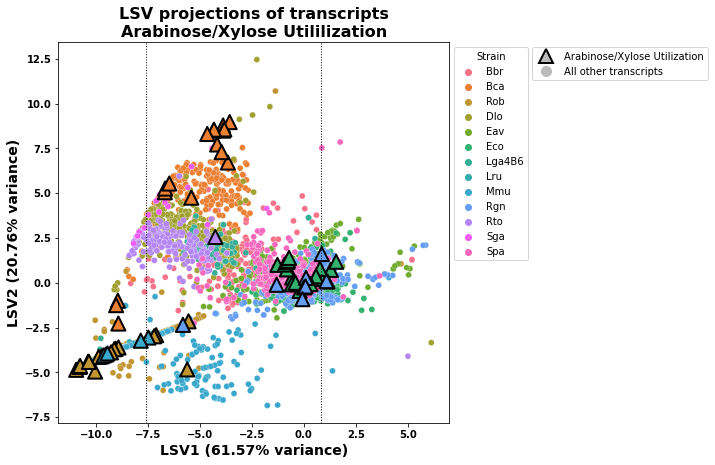

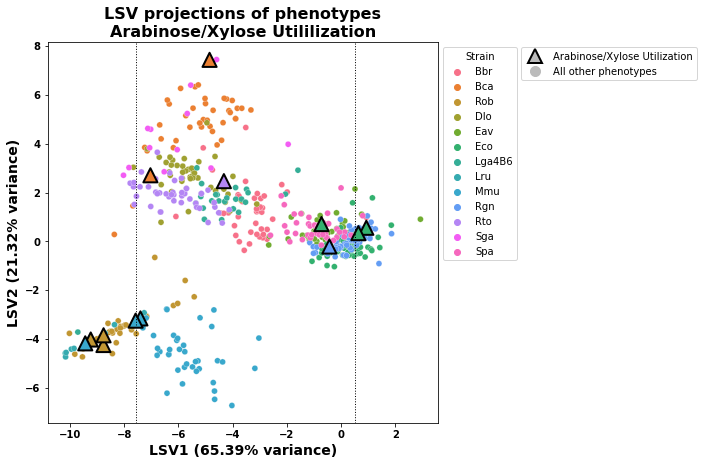

In [36]:


def LSV_feature_projections_partition(expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                                      feature_type="transcript",title_str="",partition_label="",fig_fpath=""):
    #SVD 
    if feature_type=="transcript":
        u,s,vh = svd(expr_df)
    elif feature_type=="phenotype":
        u,s,vh = svd(expr_df,full_matrices=True)
    else:
        raise ValueError("feature_type must be 'transcript' or 'phenotype'")
    eigenvalues = s**2/(len(s)-1)
    expl_variance = eigenvalues / np.sum(eigenvalues)
    #Feature projections of expr_df 
    feature_projections = sv_projections(expr_df,u,s,vh,axis=1,pc_indices=pc_indices)
    PC_columns = ["LSV{0}".format(pc_idx+1) for pc_idx in pc_indices]
    fp_df = pd.DataFrame(data=feature_projections.T,columns=PC_columns)
    fp_df.set_index(expr_df.columns,inplace=True)
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    #mcseed annotation of fp_df 
    if feature_type=="transcript":
        mcseed_filt = mcseed_df.loc[mcseed_df.index.isin(fp_df.index),:]
        fp_mcseed_join = fp_df.merge(right=mcseed_filt,left_index=True,right_index=True,sort=True)
        fp_df_mcseed = fp_mcseed_join.loc[fp_df.index,:].drop_duplicates(subset=fp_mcseed_join.columns[:5])
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.loc[:,"Isolate name"].map(STRAIN_TAGS)
    elif feature_type=="phenotype":
        fp_df_mcseed = fp_df.copy()
        fp_df_mcseed.loc[:,"Strain abbreviation"] = fp_df_mcseed.index.str.extract("(\w+?)\_[\w\-]+",expand=False)
        fp_df_mcseed.loc[:,"Phenotype"] = fp_df_mcseed.index.str.extract("\w+?\_([\w\-]+)",expand=False)
    
    #Deprecated - string version of phenotype lists from mcseed_df  
    #convert list of partition col match values into re, use str.match (for transcripts which may have more than one
    #associated phenotype)
    if(type(fp_df_mcseed["Phenotype"].iloc[0])) == list:
        #TODO: fill me 
        pass
    elif(type(fp_df_mcseed["Phenotype"].iloc[0])) == str:
        match_pattern = '|'.join(partition_values)
        partition_match = fp_df_mcseed.loc[fp_df_mcseed[partition_col].str.match(match_pattern)]
        partition_rest = fp_df_mcseed.loc[~fp_df_mcseed[partition_col].str.match(match_pattern)]
    
#     print(partition_match[partition_col].unique())
    #strain palette in dict format, keyed by abbreviation so partition data points have correct colors 
    strain_palette = sns.color_palette("husl", len(fp_df_mcseed["Strain abbreviation"].unique()))
    strain_palette = dict(zip(fp_df_mcseed["Strain abbreviation"].unique(),strain_palette))
    #Scatter plot for rest, then matched (triangle, black border, large markers)
    sns.scatterplot(data=partition_rest,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",linewidth=0.25)
    strain_handles,strain_labels = ax.get_legend_handles_labels() #Pass as legend labels later to prevent duplicate entries
    sns.scatterplot(data=partition_match,x="LSV1",y="LSV2",ax=ax,
                palette=strain_palette,hue="Strain abbreviation",marker="^",edgecolor="#000000",
                    linewidth=2,s=200)
    #Pyplot formatting
    xlabel = "{0} ({1}% variance)".format(PC_columns[0],"%.2f" % (expl_variance[0]*100))
    ylabel = "{0} ({1}% variance)".format(PC_columns[1],"%.2f" % (expl_variance[1]*100))
    standardize_plot_style(ax,xlabel,ylabel,title_str,legend_cols=1,legend_title="Strain",
                           legend_labels=strain_labels)
    #Partition Legend
    plt.gca().add_artist(ax.get_legend())
    rest_marker = matplotlib.lines.Line2D([],[],color="#BBBBBB",marker="o",linestyle='None',markersize=10,
                                          label="All other {0}s".format(feature_type.lower()))
    if not partition_label:
        partition_label = ", ".join(partition_values)
    partition_marker = matplotlib.lines.Line2D([],[],color="#BBBBBB",marker="^",linestyle='None',
                                               markeredgecolor='black',markeredgewidth=2,
                                               markersize=14,label=partition_label)
    LSV_percentile_vlines(fp_df_mcseed,ax,LSV_col="LSV{0}".format(pc_indices[0]+1))
    ax.legend(handles=[partition_marker,rest_marker])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.2,1))
    #Save figure if fig_path provided 
    if fig_fpath: 
        plt.savefig(fig_fpath,dpi=300,bbox_inches="tight",facecolor="white",format="pdf")
    return fig, fp_df_mcseed
#Transcript LSV projections with fermentation partition   
fermentation_phts = ["Propionate","Acetate","Formate"]
# fermentation_phts = ["Propionate"]
fermentation_lactate_phts = ["Propionate","Acetate","Ethanol","L-Lactate","D-Lactate","Lac_ut"]
ara_xyl_phts = ["Ara","Xyl","XOS","aAOS"]
bcaa_glu_phts = ["Glu","Gln","Leu","Val","Ile"]

plot_transcript_partitions = True
if plot_transcript_partitions:
    #Transcript LSV projections with fermentation partition
#     title_str = "LSV projections of transcripts\n Propionate/Acetate/Formate Fermentation"
#     fig_fpath = "{0}/transcript_LSV_fermentation.pdf".format(figures_dir)
#     partition_col = "Phenotype"
#     partition_values = fermentation_phts
#     partition_label = "SCFA Fermentation"
#     fig, fp_tr_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
#                             feature_type="transcript",
#                            title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)

    #Transcript LSV projections with Ara/Xyl partition
    title_str = "LSV projections of transcripts\nArabinose/Xylose Utililization"
    fig_fpath = "{0}/transcript_LSV_AraXyl.pdf".format(figures_dir)
    partition_col = "Phenotype"
    partition_values = ara_xyl_phts
    partition_label = "Arabinose/Xylose Utilization"
    fig, fp_tr_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                            feature_type="transcript",
                           title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)
    
    #Transcript LSV projections with BCAA/Gln partition
#     title_str = "LSV projections of transcripts\nBCAA/Glutamine Utililization"
#     fig_fpath = "{0}/transcript_LSV_BCAA,Gln.pdf".format(figures_dir)
#     partition_col = "Phenotype"
#     partition_values = bcaa_glu_phts
#     partition_label = "BCAA/Glutamine Biosynthesis"
#     fig, fp_tr_mcseed = LSV_feature_projections_partition(bpm_filt_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
#                             feature_type="transcript",
#                            title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)
    
plot_phenotype_partitions = True 
if plot_phenotype_partitions:

#     title_str = "LSV projections of phenotypes\nPropionate/Acetate/Formate Fermentation"
#     fig_fpath = "{0}/pht_LSV_fermentation.pdf".format(figures_dir)
#     partition_col = "Phenotype"
#     partition_values = fermentation_phts
#     partition_label = "SCFA Fermentation"
#     fig, fp_pht_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
#                             feature_type="phenotype",
#                            title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)



    title_str = "LSV projections of phenotypes\nArabinose/Xylose Utililization"
    fig_fpath = "{0}/pht_LSV_AraXyl.pdf".format(figures_dir)
    partition_col = "Phenotype"
    partition_values = ara_xyl_phts
    partition_label = "Arabinose/Xylose Utilization"
    fig, fp_pht_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
                            feature_type="phenotype",
                           title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)
    
    #Phenotype LSV projections with BCAA/Gln partition
#     title_str = "LSV projections of transcripts\nBCAA/Glutamine Utililization"
#     fig_fpath = "{0}/pht_LSV_BCAA,Gln.pdf".format(figures_dir)
#     partition_col = "Phenotype"
#     partition_values = bcaa_glu_phts
#     partition_label = "BCAA/Glutamine Biosynthesis"
#     fig, fp_pht_mcseed = LSV_feature_projections_partition(condensed_agg_expr_df,pc_indices,mcseed_df,partition_col,partition_values,
#                             feature_type="phenotype",
#                            title_str=title_str,fig_fpath=fig_fpath,partition_label=partition_label)



In [37]:
##Overall strongest LSV +/- projections: 10th percentile##
print("Top and bottom percentiles of LSV1")
bottom_pht,top_pht = LSV_percentiles(fp_pht_mcseed,LSV_col="LSV1",percentile=10)
bottom_tr,top_tr = LSV_percentiles(fp_tr_mcseed,LSV_col="LSV1",percentile=10)
SHOW_PERCENTILES=False
if SHOW_PERCENTILES:
    display(bottom_pht)
    display(top_pht)

# print("Top and bottom percentiles of LSV2")
# bottom_pht,top_pht = LSV_percentiles(fp_pht_mcseed,LSV_col="LSV2",percentile=10)
# bottom_tr,top_tr = LSV_percentiles(fp_tr_mcseed,LSV_col="LSV2",percentile=10)
# display(bottom_pht)
# display(top_pht)

Top and bottom percentiles of LSV1


/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 23.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


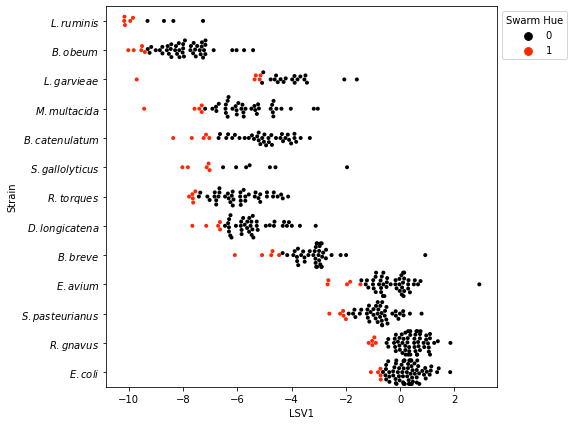

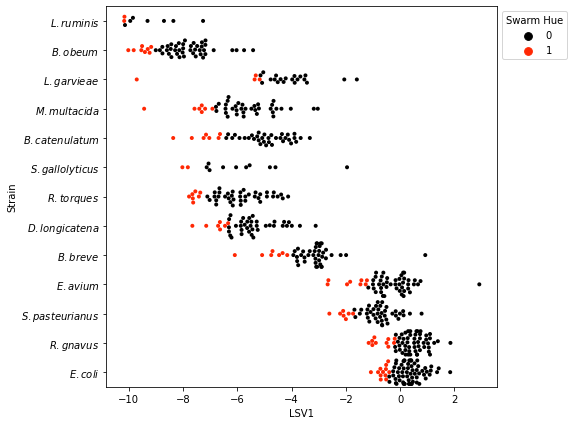

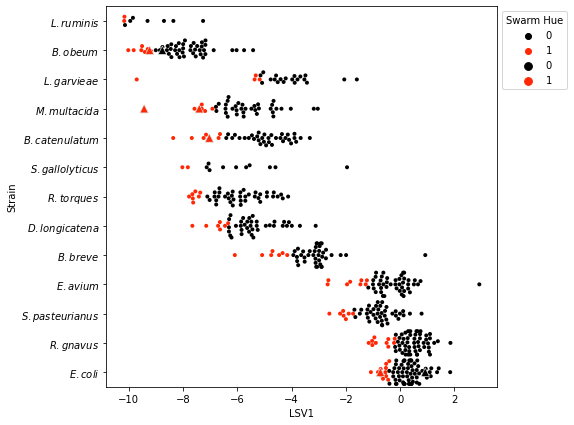

In [38]:
#Strain phenotype swarmplot
def pht_swarmplot(fp_pht_df, swarm_fpath="",palette_style="2hue",emphasized_strains=[],strain_ranking="maxLSV1",
                 pht_cutoff=5,pht_cutoff_type="top",partition_phts=[]):
    """
    @param pht_cutoff: int, either the number or the percentile value of top phenotypes to color
    @param pht_cutoff_type: 'top' or 'percentile,' how pht_cutoff should be used 
    """
    if palette_style == "2hue":
        pht_swarmplot_palette = {0:"#000000",1:"#FF2804"}
    elif palette_style == "4hue":
        assert len(emphasized_strains)>0, "Must provide emphasized_strains for palette_style='4hue'"
#         pht_swarmplot_palette = {0:"#D4D4D4",1:"#FEACA7",2:"#000000",3:"#FF2804"} #og bar/point palette colors
        pht_swarmplot_palette = {0:"#AAAAAA",1:"#F56B66",2:"#000000",3:"#FF2804"}

    fp_swarm_data = fp_pht_df.copy()
    fp_swarm_data.loc[:,"Taxa"] = fp_swarm_data.loc[:,"Strain abbreviation"].map(dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES)))

    strain_lsv_ranking = []
    for strain in fp_swarm_data["Strain abbreviation"].unique():
        strain_swarm_df = fp_swarm_data.loc[fp_swarm_data["Strain abbreviation"]==strain]
        sorted_strain_data = strain_swarm_df.sort_values("LSV1")
        if pht_cutoff_type == 'top':
            sorted_strain_data.loc[:,"pht_cutoff"] = [True]*pht_cutoff+[False]*(len(sorted_strain_data)-pht_cutoff)
        elif pht_cutoff_type == 'percentile':
            percentile_cutoff = int(np.ceil(len(sorted_strain_data)*pht_cutoff*0.01))
            sorted_strain_data.loc[:,"pht_cutoff"] = [True]*percentile_cutoff+[False]*(len(sorted_strain_data)-percentile_cutoff)
        fp_swarm_data.loc[sorted_strain_data.index,"pht_cutoff"] = sorted_strain_data.loc[:,"pht_cutoff"]
        if strain_ranking == "maxLSV1":
            strain_lsv_ranking.append((strain,sorted_strain_data.iloc[0,:]["LSV1"])) #Max LSV1 projection sorting
        elif strain_ranking=="avgLSV1":
            strain_lsv_ranking.append((strain,sorted_strain_data["LSV1"].mean())) #Avg LSV1 projection for sorting

    if palette_style == '2hue':
        fp_swarm_data.loc[:,"Swarm Hue"] = fp_swarm_data["pht_cutoff"].astype(int)
    elif palette_style == '4hue':
        fp_swarm_data.loc[:,"Swarm Hue"] = fp_swarm_data["Strain abbreviation"].isin(emphasized_strains).astype(int)*2 + \
                                            fp_swarm_data["pht_cutoff"].astype(int) #4 hue palette format
    strains_lsv_sorted = sorted(strain_lsv_ranking,key=lambda x:x[1])
    lsv_strain_order = [tup[0] for tup in strains_lsv_sorted]

    ordered_strain_dfs = []
    for strain in lsv_strain_order:
        ordered_strain_dfs.append(fp_swarm_data[fp_swarm_data["Strain abbreviation"]==strain])
    ordered_swarm_data = pd.concat(ordered_strain_dfs)

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    if len(partition_phts) > 0: 
        #partition into matching phts and rest 
        partition_swarm_data = ordered_swarm_data.loc[ordered_swarm_data["Phenotype"].isin(partition_phts)]
        rest_swarm_data = ordered_swarm_data.loc[~ordered_swarm_data["Phenotype"].isin(partition_phts)]
        rest_strains = rest_swarm_data["Strain abbreviation"].unique().tolist()
        #Y_position handling to ensure alignment of strains in partition and rest 
        partition_swarm_data.loc[:,"y_pos"] = partition_swarm_data.loc[:,"Strain abbreviation"].apply(lambda x: rest_strains.index(x))
        sns.scatterplot(data=partition_swarm_data,x="LSV1",y="y_pos",hue="Swarm Hue",
                        palette=pht_swarmplot_palette,marker="^",ax=ax,zorder=1,edgecolor='#DDDDDD',
                       s=70,linewidths=2)
        sns.swarmplot(data=rest_swarm_data,x="LSV1",y="Strain abbreviation",hue="Swarm Hue",palette=pht_swarmplot_palette,
                 size=4,ax=ax,zorder=0) #Plot partition using scatterplot since seaborn doesn't overlay swarmplots well
    else:
        sns.swarmplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",hue="Swarm Hue",palette=pht_swarmplot_palette,
                 size=4)
    ytick_labels = ax.get_yticklabels()
    matched_taxa_labels = [dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES))[label.get_text()] for label in ytick_labels]
    formatted_taxa_labels = ["$\it{0}$".format(label) for label in matched_taxa_labels]
    ax.set_yticklabels(formatted_taxa_labels)
    ax.set_ylabel("Strain")
    # standardize_plot_style(ax,"LSV1 Weight","Strain","")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
    if swarm_fpath:
        plt.savefig(swarm_fpath,dpi=300,facecolor="w",bbox_inches="tight")
    return fig,ordered_swarm_data

swarm_figs_dir = "{0}/swarmplot".format(figures_dir)
if not os.path.exists(swarm_figs_dir):
    os.makedirs(swarm_figs_dir)

emphasized_strains = ["Bca","Rob","Mmu"]
strain_ranking = "maxLSV1"
pht_cutoff_type = "top"
pht_cutoff = 5

palette_style = "2hue"
pht_cutoff_type = "top"
pht_cutoff = 5
swarm_fpath = "{0}/pht_swarmplot_{1}_{2}_{3}{4}.pdf".format(swarm_figs_dir,palette_style,strain_ranking,
                                                               pht_cutoff_type,pht_cutoff)
fig, ordered_swarm_data_top5 = pht_swarmplot(fp_pht_mcseed, swarm_fpath,palette_style=palette_style,
                                            emphasized_strains=emphasized_strains,strain_ranking="maxLSV1",
                                             pht_cutoff=pht_cutoff,pht_cutoff_type=pht_cutoff_type)

palette_style = "2hue"
pht_cutoff_type = "percentile"
pht_cutoff = 15
swarm_fpath = "{0}/pht_swarmplot_{1}_{2}_{3}{4}.pdf".format(swarm_figs_dir,palette_style,strain_ranking,
                                                               pht_cutoff_type,pht_cutoff)
fig, ordered_swarm_data_p15 = pht_swarmplot(fp_pht_mcseed, swarm_fpath,palette_style=palette_style,
                                            emphasized_strains=emphasized_strains,strain_ranking="maxLSV1",
                                             pht_cutoff=pht_cutoff,pht_cutoff_type=pht_cutoff_type)

palette_style = "2hue"
partition_phts = ["Xyl","Ara"]
partition_tag = "XylAra"
pht_cutoff_type = "percentile"
pht_cutoff = 15
swarm_fpath = "{0}/pht_swarmplot_{1}_{2}_{3}{4}_{5}.pdf".format(swarm_figs_dir,palette_style,strain_ranking,
                                                               pht_cutoff_type,pht_cutoff,partition_tag)
fig, ordered_swarm_data_p15 = pht_swarmplot(fp_pht_mcseed, swarm_fpath,palette_style=palette_style,
                                            emphasized_strains=emphasized_strains,strain_ranking="maxLSV1",
                                             pht_cutoff=pht_cutoff,pht_cutoff_type=pht_cutoff_type,
                                       partition_phts=partition_phts)

/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 23.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


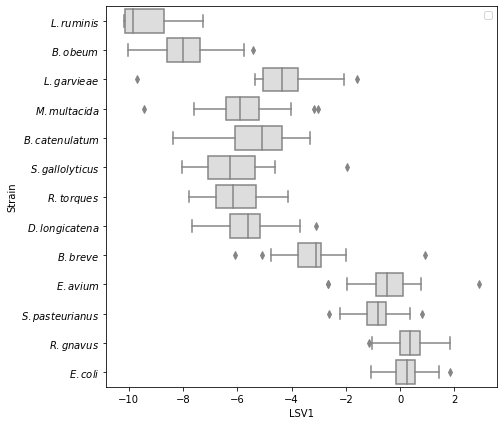

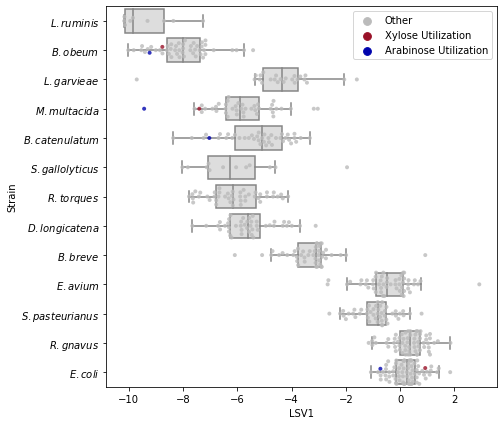

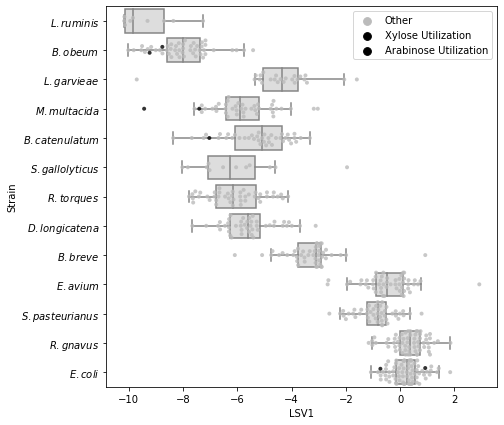

In [39]:
#Strain phenotype swarmplot
def pht_boxplot(fp_pht_df, swarm_fpath="",strain_ranking="maxLSV1",partition_phts=[],swarm_overlay=True,
               swarm_partition_palette={}):
    """
    @param pht_cutoff: int, either the number or the percentile value of top phenotypes to color
    @param pht_cutoff_type: 'top' or 'percentile,' how pht_cutoff should be used 
    """
    if palette_style == "2hue":
        pht_swarmplot_palette = {0:"#000000",1:"#FF2804"}
    elif palette_style == "4hue":
        assert len(emphasized_strains)>0, "Must provide emphasized_strains for palette_style='4hue'"
#         pht_swarmplot_palette = {0:"#D4D4D4",1:"#FEACA7",2:"#000000",3:"#FF2804"} #og bar/point palette colors
        pht_swarmplot_palette = {0:"#AAAAAA",1:"#F56B66",2:"#000000",3:"#FF2804"}

    fp_swarm_data = fp_pht_df.copy()
    fp_swarm_data.loc[:,"Taxa"] = fp_swarm_data.loc[:,"Strain abbreviation"].map(dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES)))

    strain_lsv_ranking = []
    for strain in fp_swarm_data["Strain abbreviation"].unique():
        strain_swarm_df = fp_swarm_data.loc[fp_swarm_data["Strain abbreviation"]==strain]
        sorted_strain_data = strain_swarm_df.sort_values("LSV1")
        if strain_ranking == "maxLSV1":
            strain_lsv_ranking.append((strain,sorted_strain_data.iloc[0,:]["LSV1"])) #Max LSV1 projection sorting
        elif strain_ranking=="avgLSV1":
            strain_lsv_ranking.append((strain,sorted_strain_data["LSV1"].mean())) #Avg LSV1 projection for sorting
    strains_lsv_sorted = sorted(strain_lsv_ranking,key=lambda x:x[1])
    lsv_strain_order = [tup[0] for tup in strains_lsv_sorted]
    ordered_strain_dfs = []
    for strain in lsv_strain_order:
        ordered_strain_dfs.append(fp_swarm_data[fp_swarm_data["Strain abbreviation"]==strain])
    ordered_swarm_data = pd.concat(ordered_strain_dfs)

    fig, ax = plt.subplots(1,1,figsize=(7,7))
    if swarm_overlay:
        sns.boxplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",ax=ax,color="#DDDDDD",zorder=1,fliersize=0)
        if len(partition_phts) > 0:
            def partition_idx_split(pht):
                try:
                    return partition_phts.index(pht)
                except:
                    return -1
            ordered_swarm_data.loc[:,"partition"] = ordered_swarm_data.loc[:,"Phenotype"].apply(partition_idx_split)
            sns.swarmplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",hue="partition",
                          ax=ax,palette=swarm_partition_palette,alpha=0.8,size=4,zorder=2)
        else:
            sns.swarmplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",color="#BBBBBB",
                          ax=ax,alpha=0.8,size=4,zorder=2)
    else:
        sns.boxplot(data=ordered_swarm_data,x="LSV1",y="Strain abbreviation",ax=ax,color="#DDDDDD",zorder=1)
    ytick_labels = ax.get_yticklabels()
    matched_taxa_labels = [dict(zip(STRAIN_ABBREVS,STRAIN_TAXA_NAMES))[label.get_text()] for label in ytick_labels]
    formatted_taxa_labels = ["$\it{0}$".format(label) for label in matched_taxa_labels]
    ax.set_yticklabels(formatted_taxa_labels)
    ax.set_ylabel("Strain")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles,["Other"]+[pht_pathway_df.loc[pht,"Functional pathway"] for pht in partition_phts])
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
    if swarm_fpath:
        plt.savefig(swarm_fpath,dpi=300,facecolor="w",bbox_inches="tight")
    return fig,ordered_swarm_data

swarm_figs_dir = "{0}/swarmplot".format(figures_dir)
if not os.path.exists(swarm_figs_dir):
    os.makedirs(swarm_figs_dir)

strain_ranking = "maxLSV1"
swarm_fpath = "{0}/pht_boxplot_{1}.pdf".format(swarm_figs_dir,strain_ranking)
fig, _ = pht_boxplot(fp_pht_mcseed, swarm_fpath,strain_ranking="maxLSV1",swarm_overlay=False)

# partition_phts = ["Xyl","Ara","aAOS","XOS"]
partition_phts = ["Xyl","Ara"]
xyl_ara_palette = {-1:"#BBBBBB",0:"#991128",1:"#0003AD"}
partition_tag = "XylAra"
swarm_fpath = "{0}/pht_boxswarmplot_{1}_{2}_3color.pdf".format(swarm_figs_dir,strain_ranking,partition_tag)
fig, _ = pht_boxplot(fp_pht_mcseed, swarm_fpath,strain_ranking="maxLSV1",
                                       partition_phts=partition_phts,swarm_partition_palette=xyl_ara_palette)

xyl_ara_palette = {-1:"#BBBBBB",0:"#000000",1:"#000000"}
swarm_fpath = "{0}/pht_boxswarmplot_{1}_{2}_binary.pdf".format(swarm_figs_dir,strain_ranking,partition_tag)
fig, ordered_boxswarm_data = pht_boxplot(fp_pht_mcseed, swarm_fpath,strain_ranking="maxLSV1",
                                       partition_phts=partition_phts,swarm_partition_palette=xyl_ara_palette)

/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/evanlee/opt/anaconda3/envs/gordon/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 23.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


,LSV1,LSV2,Strain abbreviation,Phenotype,Taxa,pht_cutoff,Swarm Hue,Functional category,Category Hue
Rob_Glc,-8.521959,-3.691909,Rob,Glc,B. obeum,False,0,Carbohydrate utilization,-1.0
Rob_GlcNAc,-8.130270,-3.486906,Rob,GlcNAc,B. obeum,False,0,Carbohydrate utilization,-1.0
Rob_Xyl,-8.762916,-4.247390,Rob,Xyl,B. obeum,True,1,Carbohydrate utilization,0.0
Rob_Ara,-9.231861,-4.021766,Rob,Ara,B. obeum,True,1,Carbohydrate utilization,0.0
Rob_Fuc,-7.728744,-3.624644,Rob,Fuc,B. obeum,False,0,Carbohydrate utilization,-1.0
...,...,...,...,...,...,...,...,...,...
Eco_BA_t,-0.254656,-0.329201,Eco,BA_t,E. coli,True,1,Other catabolic pathways,4.0
Eco_Lys_d,0.541805,-0.124035,Eco,Lys_d,E. coli,False,0,Other catabolic pathways,-1.0
Eco_Pro_d,-1.075787,-0.816404,Eco,Pro_d,E. coli,True,1,Other catabolic pathways,4.0
Eco_Thr_d,0.944465,0.207662,Eco,Thr_d,E. coli,False,0,Other catabolic pathways,-1.0


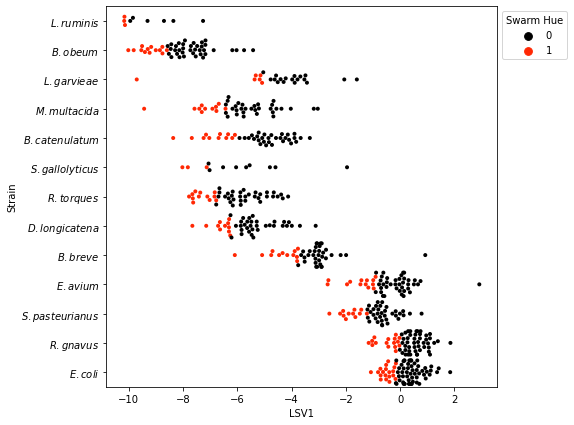

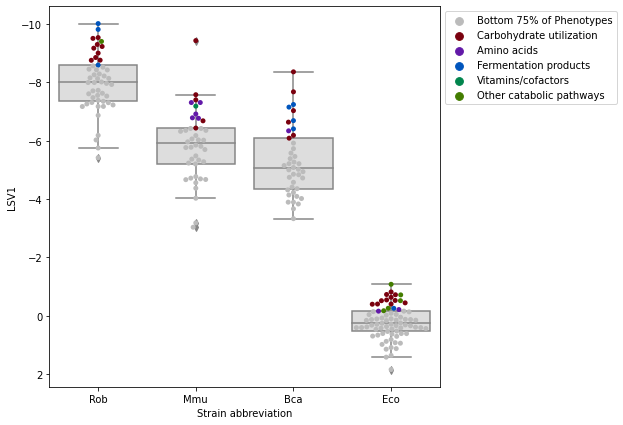

In [40]:
# display(ordered_boxswarm_data)
specific_function_dict ={"Gln":0,"Glu":0,}

func_cat_palette = {-1:"#BBBBBB",0:"#7A010F",1:"#6219A8",2:"#0055BD",3:"#00854D",4:"#437D00"}


XA_strains = ["Rob","Bca","Mmu","Eco"]
# XA_boxswarm = ordered_boxswarm_data.loc[ordered_boxswarm_data["Strain abbreviation"].isin(XA_strains)]
# XA_boxswarm.loc[:,"Functional category"] = XA_boxswarm.loc[:,"Phenotype"].map(pht_pathway_df["Functional category"])

palette_style = "2hue"
pht_cutoff_type = "percentile"
pht_cutoff = 25
swarm_fpath = ""
fig, ordered_swarm_data_p25 = pht_swarmplot(fp_pht_mcseed, swarm_fpath,palette_style=palette_style,
                                            emphasized_strains=emphasized_strains,strain_ranking="maxLSV1",
                                             pht_cutoff=pht_cutoff,pht_cutoff_type=pht_cutoff_type)

XA_p25_annotated = ordered_swarm_data_p25.loc[ordered_swarm_data_p25["Strain abbreviation"].isin(XA_strains)]

XA_p25_annotated.loc[:,"Functional category"] = XA_p25_annotated.loc[:,"Phenotype"].map(pht_pathway_df.loc[:,"Functional category"])

XA_p25_false = XA_p25_annotated.loc[XA_p25_annotated["pht_cutoff"]==False]
XA_p25_annotated.loc[XA_p25_false.index,"Category Hue"] = [-1]*len(XA_p25_false)
XA_p25_true = XA_p25_annotated.loc[XA_p25_annotated["pht_cutoff"]==True]
unique_cats = pht_pathway_df["Functional category"].unique().tolist()

XA_p25_annotated.loc[XA_p25_true.index,"Category Hue"] = XA_p25_true.loc[:,"Functional category"].apply(lambda x: unique_cats.index(x))
display(XA_p25_annotated)

fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.boxplot(data=XA_p25_annotated,x="Strain abbreviation",y="LSV1",color="#DDDDDD",zorder=1,ax=ax)
sns.swarmplot(data=XA_p25_annotated,x="Strain abbreviation",y="LSV1",hue="Category Hue",palette=func_cat_palette,ax=ax,zorder=2)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymax,ymin)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,["Bottom 75% of Phenotypes"]+unique_cats)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

XA_strain_bs_fpath = "{0}/4strain_top_phts.pdf".format(swarm_figs_dir)
plt.savefig(XA_strain_bs_fpath,dpi=300,facecolor="white",bbox_inches="tight")

In [24]:


ordered_swarm_data = ordered_swarm_data_top5 
top5_phts = ordered_swarm_data.loc[ordered_swarm_data["pht_cutoff"]]
top5_df = pd.DataFrame(index=top5_phts["Strain abbreviation"].unique(),columns=range(1,6))
for strain in top5_phts["Strain abbreviation"].unique():
    strain_top5_phts = top5_phts.loc[top5_phts["Strain abbreviation"]==strain]
    strain_top5_phts.sort_values("LSV1",inplace=True)
    for i in range(5):
        ith_pht = strain_top5_phts.iloc[i]["Phenotype"]
        ith_pathway = pht_pathway_df.loc[ith_pht,"Functional pathway"]
        top5_df.loc[strain,i+1] = ith_pathway
display(top5_df)
top5_df.to_csv("{0}/top5_phts.csv".format(swarm_figs_dir))
#     display()

/var/folders/76/sjjm9lq14pd22nymd3jmmxjh0000gn/T/ipykernel_53337/2326000158.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strain_top5_phts.sort_values("LSV1",inplace=True)


,1,2,3,4,5
Lru,Formate Production,Ethanol Production,L-Lactate Production,Mannose Utilization,"Plp/Pmp Cofactors, De Novo Synthesis"
Rob,Acetate Production,Fucosides Utilization,Xylooligosaccharides Utilization,Glutamine Biosynthesis,Propionate Production
Lga4B6,N-Acetylmuramic Acid Utilization,N-Acetylglucosamine Utilization,Mannose Utilization,Threonine Degradation,Aspartate Biosynthesis
Sga,Sucrose Utilization,Fructose Utilization,Alpha-Galactosides Utilization,Ethanol Production,Glucoselysine Utilization
Bca,Melibiose Utilization,Arabinose Utilization,Ethanol Production,Raffinose Utilization,Lactose Utilization
Rto,Isoleucine Biosynthesis,Valine Biosynthesis,Fructose Utilization,Sucrose Utilization,Rhamnose Utilization
Mmu,Arabinose Utilization,"Queuosine, De Novo Synthesis",Tyrosine Biosynthesis,Phenylalanine Biosynthesis,Glutamate Biosynthesis
Dlo,Threonine Degradation,Trehalose Utilization,Acetate Production,Galactose Utilization,Formate Production
Bbr,N-Acetylneuraminate Utilization,Raffinose Utilization,Methionine Biosynthesis,Melibiose Utilization,Acetate Production
Eav,Ribose Utilization,Allose Utilization,Beta-Mannooligosaccharides Utilization,Beta-Glucosides Utilization,Serine Biosynthesis


In [41]:
#Ara and Xyl pht, all strains 
ara_xyl_phts = ["Ara","Xyl"]
ara_xyl_os_phts = ["Ara","Xyl","XOS","aAOS"]
display(fp_pht_mcseed[fp_pht_mcseed["Phenotype"].isin(ara_xyl_phts)])
display(fp_pht_mcseed[fp_pht_mcseed["Phenotype"].isin(ara_xyl_os_phts)])
#R. obeum transcripts with Ara/Xyl annotation 
AX_match_pattern = '|'.join(["Ara","Xyl","aAOS","XOS"])
Rob_top3_match = '|'.join(["Xyl","Acetate","Gln"])
Mmu_top3_match = '|'.join(["Ara","Leu","Glu"])

BCAA_match = '|'.join(["Leu","Ile","Val"])
Gln_match = '|'.join(["Gln","Glu"])

#Ara Xyl aAOS XOS 
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Bca")
                     & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
                     & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
                     & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))].sort_values("LSV1"))

#deprecated - E6 cecal 0.3 top 3 phenotype results 
# display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
#                      & (fp_tr_mcseed["Phenotype"].str.contains(Rob_top3_match))].sort_values("LSV1"))
# display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
#                      & (fp_tr_mcseed["Phenotype"].str.contains(Mmu_top3_match))].sort_values("LSV1"))


display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
                     & (fp_tr_mcseed["Phenotype"].str.contains(Gln_match))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
                     & (fp_tr_mcseed["Phenotype"].str.contains(Gln_match))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Mmu")
                     & (fp_tr_mcseed["Phenotype"].str.contains(BCAA_match))].sort_values("LSV1"))
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rto")
                     & (fp_tr_mcseed["Phenotype"].str.contains(BCAA_match))].sort_values("LSV1"))

,LSV1,LSV2,Strain abbreviation,Phenotype
Bca_Ara,-7.031336,2.705485,Bca,Ara
Rob_Xyl,-8.762916,-4.247390,Rob,Xyl
Rob_Ara,-9.231861,-4.021766,Rob,Ara
Eco_Xyl,0.926743,0.555644,Eco,Xyl
Eco_Ara,-0.725856,0.707388,Eco,Ara
Mmu_Xyl,-7.400005,-3.157694,Mmu,Xyl
Mmu_Ara,-9.433491,-4.178463,Mmu,Ara


,LSV1,LSV2,Strain abbreviation,Phenotype
Bca_Ara,-7.031336,2.705485,Bca,Ara
Bca_aAOS,-4.851346,7.434340,Bca,aAOS
Rob_Xyl,-8.762916,-4.247390,Rob,Xyl
Rob_Ara,-9.231861,-4.021766,Rob,Ara
Rob_XOS,-8.758859,-3.848549,Rob,XOS
Eco_Xyl,0.926743,0.555644,Eco,Xyl
Eco_Ara,-0.725856,0.707388,Eco,Ara
Eco_XOS,0.633606,0.335892,Eco,XOS
Mmu_Xyl,-7.400005,-3.157694,Mmu,Xyl
Mmu_Ara,-9.433491,-4.178463,Mmu,Ara


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
NNMNEBCK_00989,-9.033342,-1.249188,Bifidobacterium catenulatum Bgsng468_m22_84,AraH,L-arabinose transport system permease protein ...,Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_00988,-8.951388,-1.003153,Bifidobacterium catenulatum Bgsng468_m22_84,AraG,L-arabinose transport ATP-binding protein AraG...,Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_00987,-8.924522,-2.275596,Bifidobacterium catenulatum Bgsng468_m22_84,AraF,L-arabinose-binding periplasmic protein precur...,Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_01775,-6.687743,5.050494,Bifidobacterium catenulatum Bgsng468_m22_84,AraA,L-arabinose isomerase (EC 5.3.1.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Bca
NNMNEBCK_01776,-6.674543,5.257045,Bifidobacterium catenulatum Bgsng468_m22_84,AraD,L-ribulose-5-phosphate 4-epimerase (EC 5.1.3.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Bca
NNMNEBCK_01777,-6.473539,5.537521,Bifidobacterium catenulatum Bgsng468_m22_84,AraB,Ribulokinase (EC 2.7.1.16),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Bca
NNMNEBCK_00986,-5.411277,4.747314,Bifidobacterium catenulatum Bgsng468_m22_84,AraU,Predicted transcriptional regulator of arabino...,Carbohydrate utilization,arabinose utilization,Ara,Bca
NNMNEBCK_00319,-4.645794,8.304132,Bifidobacterium catenulatum Bgsng468_m22_84,AauC,Predicted alpha-arabino-oligosaccharides ABC t...,Carbohydrate utilization,alpha-arabinooligosaccharides utilization,aAOS,Bca
NNMNEBCK_00312,-4.350468,8.487563,Bifidobacterium catenulatum Bgsng468_m22_84,AbnA,"Endo-alpha-(1->5)-L-arabinanase (EC 3.2.1.99),...",Carbohydrate utilization,alpha-arabinooligosaccharides utilization,aAOS,Bca
NNMNEBCK_00318,-4.322793,8.544262,Bifidobacterium catenulatum Bgsng468_m22_84,AauB,Predicted alpha-arabino-oligosaccharides ABC t...,Carbohydrate utilization,alpha-arabinooligosaccharides utilization,aAOS,Bca


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
HIAFFLEM_01301,-10.954577,-4.858452,Blautia obeum Bg7063_SSTS2015,XylH,"Xylose ABC transporter, permease protein XylH",Carbohydrate utilization,xylose utilization,Xyl,Rob
HIAFFLEM_02424,-10.789008,-4.697566,Blautia obeum Bg7063_SSTS2015,XylA2,predicted xylose isomerase,Carbohydrate utilization,xylose utilization; xylooligosaccharides utili...,Xyl; XOS,Rob
HIAFFLEM_02452,-10.767845,-4.641363,Blautia obeum Bg7063_SSTS2015,AraW,"Predicted L-arabinose ABC transport system, pe...",Carbohydrate utilization,arabinose utilization,Ara,Rob
HIAFFLEM_02425,-10.381866,-4.406219,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_02457,-10.342245,-4.417516,Blautia obeum Bg7063_SSTS2015,AraB,Ribulokinase (EC 2.7.1.16),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Rob
HIAFFLEM_01302,-10.044336,-4.955539,Blautia obeum Bg7063_SSTS2015,XylG,D-xylose transport ATP-binding protein XylG,Carbohydrate utilization,xylose utilization,Xyl,Rob
HIAFFLEM_02456,-9.877715,-4.140060,Blautia obeum Bg7063_SSTS2015,AraA,L-arabinose isomerase (EC 5.3.1.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Rob
HIAFFLEM_01096,-9.736382,-4.109285,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_01075,-9.527133,-4.009236,Blautia obeum Bg7063_SSTS2015,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Rob
HIAFFLEM_02458,-9.277957,-3.882085,Blautia obeum Bg7063_SSTS2015,AraD,L-ribulose-5-phosphate 4-epimerase (EC 5.1.3.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Rob


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ONMCJBAG_00857,-9.629133,-4.053015,Mitsuokella multacida DSM_20544,AraA,L-arabinose isomerase (EC 5.3.1.4),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Mmu
ONMCJBAG_00859,-9.450109,-3.942786,Mitsuokella multacida DSM_20544,AraB,Ribulokinase (EC 2.7.1.16),Carbohydrate utilization,arabinose utilization; alpha-arabinooligosacch...,Ara; aAOS,Mmu
ONMCJBAG_01615,-7.847879,-3.233060,Mitsuokella multacida DSM_20544,XynB,Beta-xylosidase (EC 3.2.1.37),Carbohydrate utilization,xylooligosaccharides utilization,XOS,Mmu
ONMCJBAG_01925,-7.483249,-3.057120,Mitsuokella multacida DSM_20544,XylB,Xylulose kinase (EC 2.7.1.17),Carbohydrate utilization,xylose utilization; xylitol utilization; arabi...,Xyl; Xlt; Atl; XOS,Mmu


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
HIAFFLEM_00410,-10.165190,-4.324729,Blautia obeum Bg7063_SSTS2015,Gdh1,NADP-specific glutamate dehydrogenase (EC 1.4....,Amino acids,glutamate biosynthesis,Glu,Rob
HIAFFLEM_00723,-10.165160,-4.315820,Blautia obeum Bg7063_SSTS2015,GlnN,"Glutamine synthetase type III, GlnN (EC 6.3.1.2)",Amino acids,glutamine biosynthesis,Gln,Rob
HIAFFLEM_03118,-9.258390,-3.843963,Blautia obeum Bg7063_SSTS2015,GltB,Glutamate synthase [NADPH] large chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Rob
HIAFFLEM_03169,-8.885888,-3.731483,Blautia obeum Bg7063_SSTS2015,GltD,Glutamate synthase [NADPH] small chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Rob
HIAFFLEM_03119,-7.471892,-3.058344,Blautia obeum Bg7063_SSTS2015,GltD,Glutamate synthase [NADPH] small chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Rob
HIAFFLEM_03125,-7.271728,-2.983838,Blautia obeum Bg7063_SSTS2015,GatB,Aspartyl-tRNA(Asn) amidotransferase subunit B ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Rob
HIAFFLEM_03125,-7.271728,-2.983838,Blautia obeum Bg7063_SSTS2015,GatB,Glutamyl-tRNA(Gln) amidotransferase subunit B ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Rob
HIAFFLEM_03124,-7.233168,-2.993781,Blautia obeum Bg7063_SSTS2015,GatA,Aspartyl-tRNA(Asn) amidotransferase subunit A ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Rob
HIAFFLEM_03124,-7.233168,-2.993781,Blautia obeum Bg7063_SSTS2015,GatA,Glutamyl-tRNA(Gln) amidotransferase subunit A ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Rob
HIAFFLEM_01314,-6.959869,-2.887635,Blautia obeum Bg7063_SSTS2015,GltB,Glutamate synthase [NADPH] large chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Rob


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ONMCJBAG_00883,-9.223963,-3.877870,Mitsuokella multacida DSM_20544,GltB,Glutamate synthase [NADPH] large chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Mmu
ONMCJBAG_01809,-8.338308,-3.494896,Mitsuokella multacida DSM_20544,GatA,Aspartyl-tRNA(Asn) amidotransferase subunit A ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Mmu
ONMCJBAG_01809,-8.338308,-3.494896,Mitsuokella multacida DSM_20544,GatA,Glutamyl-tRNA(Gln) amidotransferase subunit A ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Mmu
ONMCJBAG_00882,-7.038945,-5.846639,Mitsuokella multacida DSM_20544,GltD,Glutamate synthase [NADPH] small chain (EC 1.4...,Amino acids,glutamate biosynthesis,Glu,Mmu
ONMCJBAG_00079,-4.723001,-6.124171,Mitsuokella multacida DSM_20544,GlnA6,"Glutamine synthetase, clostridia type (EC 6.3....",Amino acids,glutamine biosynthesis,Gln,Mmu
ONMCJBAG_00446,-4.171185,-3.425183,Mitsuokella multacida DSM_20544,Gdh1,NADP-specific glutamate dehydrogenase (EC 1.4....,Amino acids,glutamate biosynthesis,Glu,Mmu
ONMCJBAG_01810,-2.518588,-5.912580,Mitsuokella multacida DSM_20544,GatB,Aspartyl-tRNA(Asn) amidotransferase subunit B ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Mmu
ONMCJBAG_01810,-2.518588,-5.912580,Mitsuokella multacida DSM_20544,GatB,Glutamyl-tRNA(Gln) amidotransferase subunit B ...,Amino acids,asparagine biosynthesis; glutamine biosynthesis,Asn; Gln,Mmu


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
ONMCJBAG_01954,-9.533218,-4.019226,Mitsuokella multacida DSM_20544,IlvE,Branched-chain amino acid aminotransferase (EC...,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01767,-8.913847,-3.726158,Mitsuokella multacida DSM_20544,LeuC,3-isopropylmalate dehydratase large subunit (E...,Amino acids,leucine biosynthesis,Leu,Mmu
ONMCJBAG_01769,-8.820335,-3.676122,Mitsuokella multacida DSM_20544,LeuB,3-isopropylmalate dehydrogenase (EC 1.1.1.85),Amino acids,leucine biosynthesis,Leu,Mmu
ONMCJBAG_02049,-8.672888,-3.638501,Mitsuokella multacida DSM_20544,IlvD,Dihydroxy-acid dehydratase (EC 4.2.1.9),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01337,-8.565947,-3.562485,Mitsuokella multacida DSM_20544,IlvA,Threonine dehydratase (EC 4.3.1.19),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_00607,-7.874454,-3.281887,Mitsuokella multacida DSM_20544,IlvM,Acetolactate synthase small subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01768,-6.989464,-2.883036,Mitsuokella multacida DSM_20544,LeuD,3-isopropylmalate dehydratase small subunit (E...,Amino acids,leucine biosynthesis,Leu,Mmu
ONMCJBAG_00732,-6.799957,-2.836086,Mitsuokella multacida DSM_20544,LivF,Branched-chain amino acid transport ATP-bindin...,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_00736,-5.896062,-5.176927,Mitsuokella multacida DSM_20544,LivB,"Branched-chain amino acid ABC transporter, ami...",Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu
ONMCJBAG_01770,-5.848942,-5.612587,Mitsuokella multacida DSM_20544,IlvG,Acetolactate synthase large subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Mmu


,LSV1,LSV2,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain abbreviation
CGCJBKJN_00471,-8.176687,2.299147,Ruminococcus torques Bg7063,IlvA,Threonine dehydratase (EC 4.3.1.19),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_00616,-7.117185,2.117367,Ruminococcus torques Bg7063,LeuC,3-isopropylmalate dehydratase large subunit (E...,Amino acids,leucine biosynthesis,Leu,Rto
CGCJBKJN_00614,-7.068818,1.779392,Ruminococcus torques Bg7063,LeuC,3-isopropylmalate dehydratase large subunit (E...,Amino acids,leucine biosynthesis,Leu,Rto
CGCJBKJN_01243,-6.297241,2.895636,Ruminococcus torques Bg7063,IlvG,Acetolactate synthase large subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_01309,-6.154421,2.608992,Ruminococcus torques Bg7063,IlvC; IlvC2,Ketol-acid reductoisomerase (NADP(+)) (EC 1.1....,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_01437,-5.983569,2.254007,Ruminococcus torques Bg7063,IlvA,Threonine dehydratase (EC 4.3.1.19),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_01244,-5.974063,2.803668,Ruminococcus torques Bg7063,IlvD,Dihydroxy-acid dehydratase (EC 4.2.1.9),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_02929,-5.534970,2.170018,Ruminococcus torques Bg7063,IlvE,Branched-chain amino acid aminotransferase (EC...,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_00455,-5.367284,1.204147,Ruminococcus torques Bg7063,IlvG,Acetolactate synthase large subunit (EC 2.2.1.6),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val,Rto
CGCJBKJN_00615,-5.367215,1.505031,Ruminococcus torques Bg7063,LeuD,3-isopropylmalate dehydratase small subunit (E...,Amino acids,leucine biosynthesis,Leu,Rto


In [ ]:
display(fp_tr_mcseed.loc[(fp_tr_mcseed["Strain abbreviation"] == "Rob")
                     & (fp_tr_mcseed["Phenotype"].str.contains(AX_match_pattern))])

In [ ]:
#TODO: bacteria by bacteria LSV projections 
# Bbr, Bca, Rob, ...  
#Eav, Eco; 

if not os.path.exists(lsv_data_path):
    os.makedirs(lsv_data_path)
# for strain in ["Bbr","Bca","Rob","Eav","Eco","Rgn","Mmu"]:
for strain in fp_pht_mcseed["Strain abbreviation"].unique():
    strain_fp = fp_pht_mcseed.loc[fp_pht_mcseed["Strain abbreviation"]==strain]
    strain_fp = strain_fp.sort_values("LSV1")#sort by LSV1
    display(strain_fp)
    strain_fpath = "{0}/{1}_LSV.csv".format(lsv_data_path,strain)
    strain_fp.to_csv(strain_fpath)
    

In [ ]:
# display(fp_pht_mcseed[fp_pht_mcseed["Phenotype"].isin(["Ara","Xyl"])])

In [ ]:
#Mapping pathways back to functional categories 
#Use mcseed_df (without list version phenotypes) for list of phenotype unique values 
pht_fc_dict = {}
for pht_str in mcseed_df["Phenotype"].unique(): #pht_str is a variable length semicolon separated string of different phenotypes
    pht_list = pht_str.split(";") 
    pht_str_rows = mcseed_df.loc[mcseed_df["Phenotype"]==pht_str,:]
    assert(len(pht_str_rows["Functional category"].unique()) == 1)
    fc_cat_str = pht_str_rows["Functional category"].iloc[0]
    fc_cat_list = fc_cat_str.split(";")
    for i,pht in enumerate(pht_list):
        if pht not in pht_fc_dict:
            if len(fc_cat_list) == 1: #If only one functional category for all entries in pht_str, use that category
                pht_fc_dict[pht] = fc_cat_list[0]
            elif len(fc_cat_list) == len(pht_list): #If one-to-one mapping of phenotypes to functional categories, go in order
                pht_fc_dict[pht] = fc_cat_list[i]
            else: #Not one-to-one mapping of phenotypes to functional categories; use some HARD CODING TM  
                print(pht_str)
                print(fc_cat_str)
                raise ValueError("Cannot automatically match phenotypes to functional categories based on prior entries")

fp_pht_mcseed.loc[:,"Functional category"] = fp_pht_mcseed["Phenotype"].map(pht_fc_dict)
display(fp_pht_mcseed)

n_fc_unique = len(fp_pht_mcseed["Functional category"].unique())
# fc_palette = sns.color_palette("husl", n_fc_unique)
fc_palette = sns.color_palette("Set2")[:n_fc_unique]
fig,axes = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = axes
#Strain phenotypes by functional category
strain_palette = sns.color_palette("husl", len(fp_pht_mcseed["Strain abbreviation"].unique()))
sns.scatterplot(data=fp_pht_mcseed,x="LSV1",y="LSV2",ax=ax1,
                palette=fc_palette,hue="Functional category")
handles,labels = ax1.get_legend_handles_labels()
ax1.legend(handles,labels,loc="best")
ax1.set_title("LSV Projections of strain phenotypes by functional category")
#Strain phenotypes by strain
sns.scatterplot(data=fp_pht_mcseed,x="LSV1",y="LSV2",ax=ax2,
                palette=strain_palette,hue="Strain abbreviation")
handles,labels = ax2.get_legend_handles_labels()
ax2.legend(handles,labels,loc="best",ncol=2)
ax2.set_title("LSV Projections of strain phenotypes by strain")
plt.savefig("{0}/feature_projections_SVD.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")

plt.savefig("{0}/phenotypes_functionalcategory_SVD.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")


In [ ]:
#SVD Feature Comparison 
u_tr,s_tr,vh_tr = svd(bpm_filt_log_df)
u_pht,s_pht,vh_pht = svd(condensed_agg_log_df,full_matrices=True)

#Explained variance calculated from s -> eigenvalues 
eigenvalues_tr = s_tr**2/(len(s_tr)-1)
expl_variance_tr = eigenvalues_tr / np.sum(eigenvalues_tr)
eigenvalues_pht = s_pht**2/(len(s_pht)-1)
expl_variance_pht = eigenvalues_pht / np.sum(eigenvalues_pht)

n_SV = 2
print("Explained Variance (Transcripts, first {0}): {1}".format(n_SV,expl_variance_tr[:n_SV]))
print("Explained Variance (Phenotype, first {0}): {1}".format(n_SV,expl_variance_pht[:n_SV]))

LSV1_tr = u_tr[:,0]
RSV1_tr = vh_tr[0,:]

print("LSV1 Transcript")
print(LSV1_tr)
print("RSV1 Transcript")
print(RSV1_tr)

LSV1_pht = u_pht[:,0]
RSV1_pht = vh_pht[0,:]

tr_10th, tr_90th = np.percentile(RSV1_tr,[10,90])
print(tr_10th,tr_90th)
pht_10th, pht_90th = np.percentile(RSV1_pht,[10,90])
print(pht_10th,pht_90th)
hist_color = sns.color_palette("Set2")[2]
vline_color = sns.color_palette("Set2")[7]
#Subplots and axes set up, grids, titles, x_labels with PC
fig,axes = plt.subplots(2,1,figsize=(8,10))
ax1,ax2 = axes
for ax in [ax1,ax2]:
    ax.grid(visible=True,color="white")
    ax.set_axisbelow(True)
    ax.set_facecolor("#EBEAF2")
    ax.set_ylabel("Counts")
ax1.set_title("Transcript Projections onto Transcript LSV1")
ax1.set_xlabel("LSV{0} ({1}% variance)".format(pc_indices[0]+1,
                                              "%.2f" % (expl_variance_tr[pc_indices[0]]*100)))
ax2.set_title("Strain Phenotype Projections onto Strain LSV1")
ax2.set_xlabel("LSV{0} ({1}% variance)".format(pc_indices[0]+1,
                                              "%.2f" % (expl_variance_pht[pc_indices[0]]*100)))
#Histogram and vline plotting for histogram 10th and 90th percentiles 
ax1.hist(RSV1_tr.flatten(),bins=25,color=hist_color)
ax1_ylim = ax1.get_ylim()
ax1.vlines([tr_10th,tr_90th],*ax1.get_ylim(),color=vline_color,linewidth=1.5)
ax1.set_ylim(ax1_ylim) #without this line vlines resets ylims for some reason - specific to using hist 
ax2.hist(RSV1_pht.flatten(),bins=25,color=hist_color)
ax2_ylim = ax2.get_ylim()
ax2.vlines([pht_10th,pht_90th],*ax2.get_ylim(),color=vline_color,linewidth=1.5)
ax2.set_ylim(ax2_ylim)

plt.savefig("{0}/LSV1_projection_histogram.png".format(figures_dir),dpi=200,bbox_inches="tight",facecolor="white")